In [ ]:
IMG_PATH = '../recursos/images/recibos/recibo006.png'

# Protótipo com Open AI - Puro

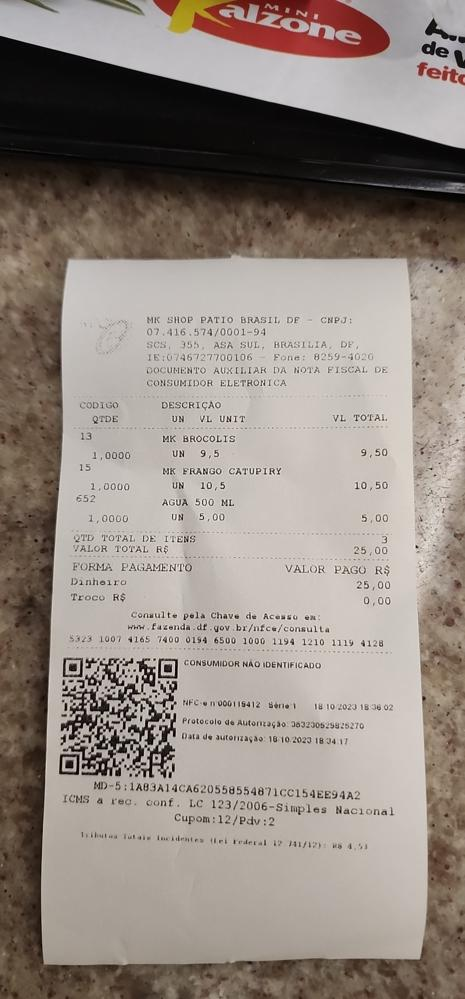

```json
{
    "empresa": "MK SHOP PÁTIO BRASIL DF",
    "data": "10/10/2023",
    "cnpj": "07416574000194",
    "tipo": "Alimentação",
    "itens": [
        {
            "descricao": "MK BROCOLIS",
            "valor_unitario": 9.5,
            "quantidade": 1,
            "valor_total": 9.5
        },
        {
            "descricao": "FRANGO CATUPIRY",
            "valor_unitario": 10.5,
            "quantidade": 1,
            "valor_total": 10.5
        },
        {
            "descricao": "AGUA 500 ML",
            "valor_unitario": 5.0,
            "quantidade": 1,
            "valor_total": 5.0
        }
    ],
    "valor_pago": 25.0
}
```


In [65]:
import base64
import os
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_community.tools import CopyFileTool
from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import HumanMessagePromptTemplate, MessagesPlaceholder
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

import PIL.Image
from IPython.display import display


class ProcessImage:
        
    def __init__(self):
        openai_api_key = os.getenv("OPENAI_API_KEY")
        self.llm = ChatOpenAI(
            model='gpt-4o-mini',
            temperature=0,
            openai_api_key=openai_api_key
        )

    def openai_analysis(self, image_path):
            
        image = PIL.Image.open(image_path)
        display(image)
        
        with open(image_path, "rb") as image_file:
            base64_image = base64.b64encode(image_file.read()).decode("UTF-8")
            
        prompt = ChatPromptTemplate.from_messages(
            messages=[
                HumanMessage(content="""Dada a imagem de uma nota fiscal de compra, extraia os dados importantes dela e retorne no seguinte formato:
                        - Empresa : nome da empresa que emitiu o recibo
                        - Data: a data que foi feita a compra
                        - CNPJ: cnpj da empresa que emitiu o recibo, sem pontuação
                        - Tipo: tipo da despesa baseada nos itens comprados, escolha uma dentre as seguintes categorias:
                                    - Alimentação
                                    - Saúde
                                    - Mercado
                                    - Compras
                                    - Transporte
                        - Itens: 
                            - Descrição: nome ou descrição da mercadoria
                            - Valor Unitário: valor unitário da mercadoria
                            - Quantidade: quantidade da mercadoria
                            - Valor Total: valor total da mercadoria
                        - Valor Pago: valor pago
                        Retorne os dados no formato JSON com nomes dos campos em snake_case.
                    {text}
                """),
                 HumanMessagePromptTemplate.from_template(
                    template=[
                        {"type": "image_url", "image_url": {"url": "{image_url}"}},
                    ]
                ),
                MessagesPlaceholder("agent_scratchpad"),
            ]
        )
        
        tools = [CopyFileTool()]
        agent = create_openai_tools_agent(self.llm, tools, prompt)
        agent_executor = AgentExecutor(
            agent=agent,
            tools=tools,
        )
        result = agent_executor.invoke({"image_url": f"data:image/jpeg;base64,{base64_image}", "agent_scratchpad": []})
        response = result['output'] 
    
        print(response)
        return response

dados = ProcessImage().openai_analysis(IMG_PATH)

# Protótipo com Open AI - Com Tratamento de Imagem antes de Enviar

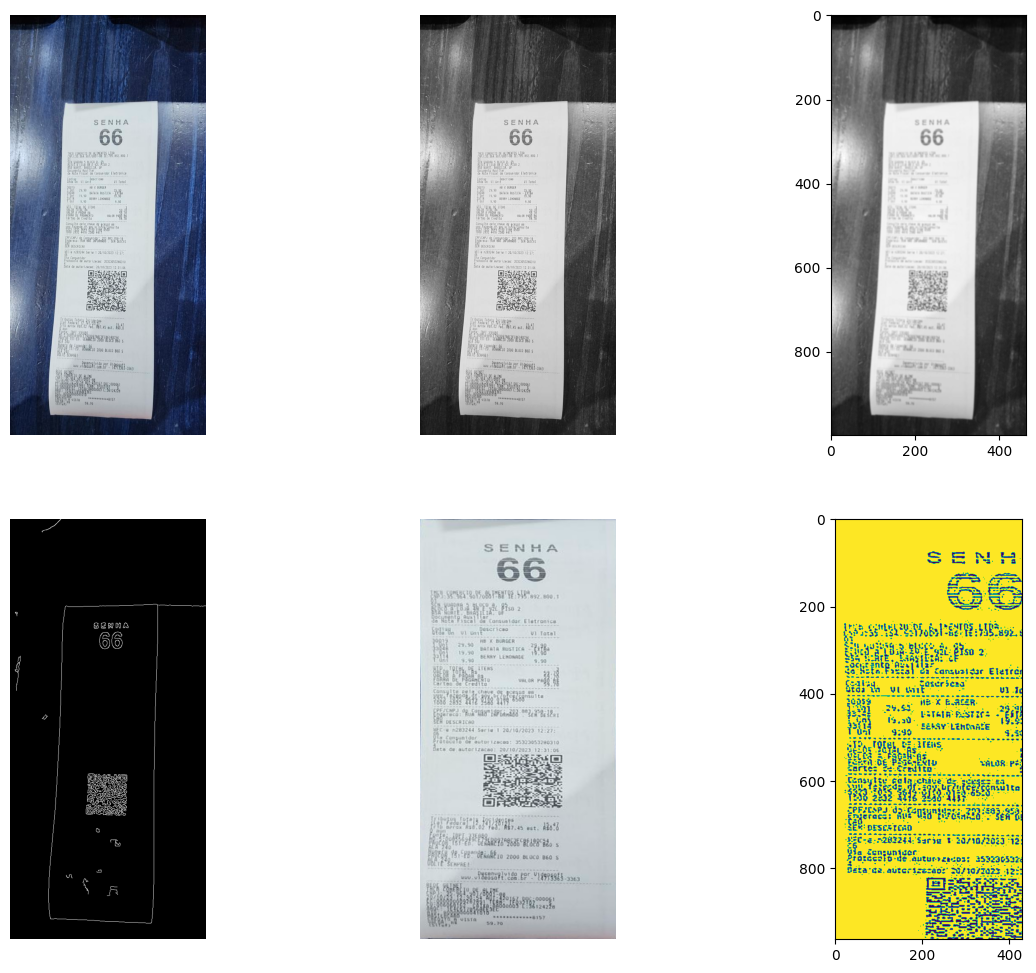

BadRequestError: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image has of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_image_format'}}

In [56]:
import base64
import os
import cv2
import imutils
import numpy as np
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_community.tools import CopyFileTool
from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import HumanMessagePromptTemplate, MessagesPlaceholder
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from matplotlib import pyplot as plt
from PIL import Image
from dotenv import load_dotenv
from io import BytesIO


load_dotenv()


class ProcessImage:
        
    def __init__(self):
        openai_api_key = os.getenv("OPENAI_API_KEY")
        self.llm = ChatOpenAI(
            model='gpt-4o-mini',
            temperature=0,
            openai_api_key=openai_api_key
        )
        
    def encontrar_contornos(self, img):
        ''' Detecção de contornos na imagem '''
        conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        conts = imutils.grab_contours(conts)
        conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
        return conts

    def encontrar_maior_contorno(self, conts):
        ''' Localizando o maior contorno com Algoritmo de Douglas-Peucker '''
        for c in conts:
            perimetro = cv2.arcLength(c, True)
            aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
            if len(aproximacao) == 4:
                return aproximacao

    def ordenar_pontos(self, pontos):
        pontos = pontos.reshape((4,2))
        pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

        add = pontos.sum(1)
        pontos_novos[0] = pontos[np.argmin(add)]
        pontos_novos[2] = pontos[np.argmax(add)]

        dif = np.diff(pontos, axis = 1)
        pontos_novos[1] = pontos[np.argmin(dif)]
        pontos_novos[3] = pontos[np.argmax(dif)]

        return pontos_novos

    def process(self, path):
        img = cv2.imread(path)
        original = img.copy()
        (H, W) = img.shape[:2]
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conversão para tons de cinza (grayscale)
        blur = cv2.GaussianBlur(gray, (7, 7), 0) # Aplicação de desfoque (Gaussian Blur)
        edged = cv2.Canny(blur, 60, 160) # Detecção de bordas (Canny Edge)
        
        conts = self.encontrar_contornos(edged.copy())
        maior = self.encontrar_maior_contorno(conts)
        cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
        cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
        pontos_maior = self.ordenar_pontos(maior)
        
        # Obtenção da matriz de transformação
        pts1 = np.float32(pontos_maior)
        pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])
        matriz = cv2.getPerspectiveTransform(pts1, pts2)
        # Transformação de perspectiva
        transform = cv2.warpPerspective(original, matriz, (W, H))
        img_maior = cv2.resize(transform, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
        
        # Aumentando o contraste e brilho
        brilho = 50
        contraste = 80
        ajustes = np.int16(img_maior)
        ajustes = ajustes * (contraste / 127 + 1) - contraste + brilho
        ajustes = np.clip(ajustes, 0, 255)
        ajustes = np.uint8(ajustes)
        
        # Limiarização Adaptativa
        img_process = cv2.cvtColor(img_maior, cv2.COLOR_BGR2GRAY)
        img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
        
        # Remoção de bordas
        margem = 18
        img_final = img_process[margem:H - margem, margem:W - margem]
        return img_final

    def processamento_img(img):
        img_process = cv2.resize(img, None, fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
        img_process = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
        return img_process

    def openai_analysis(self, image_path):
        image = Image.fromarray(self.process(image_path))
        buffered = BytesIO()
        image.save(buffered, format="jpeg")
        base64_image = base64.b64encode(buffered.getvalue())

        prompt = ChatPromptTemplate.from_messages(
            messages=[
                HumanMessage(content="""
                    Dada a imagem fornecida, extraia os dados importantes dela e retorne no seguinte formato:
                    - Empresa : nome da empresa que emitiu o recibo
                    - Tipo: tipo da despesa baseada nos itens comprados
                    - Itens: 
                        - Descrição: nome ou descrição da mercadoria
                        - Valor Unitário: valor unitário da mercadoria
                        - Quantidade: quantidade da mercadoria
                        - Valor Total: valor total da mercadoria
                    - Total: valor total da compra
                    - Desconto: valor do desconto
                    - Valor Pago: valor pago
                    Retorne os dados no formato JSON com nomes dos campos em snake_case.
                    {text}
                """),
                 HumanMessagePromptTemplate.from_template(
                    template=[
                        {"type": "image_url", "image_url": {"url": "{image_url}"}},
                    ]
                ),
                MessagesPlaceholder("agent_scratchpad"),
            ]
        )
        tools = [CopyFileTool()]
        agent = create_openai_tools_agent(self.llm, tools, prompt)
        agent_executor = AgentExecutor(
            agent=agent,
            tools=tools,
        )
        result = agent_executor.invoke({"image_url": f"data:image/jpeg;base64,{base64_image}", "agent_scratchpad": []})
        response = result['output'] 
        print(response)
        return response

ProcessImage().openai_analysis(IMG_PATH)

# Protótipo com Google Gemini - Puro

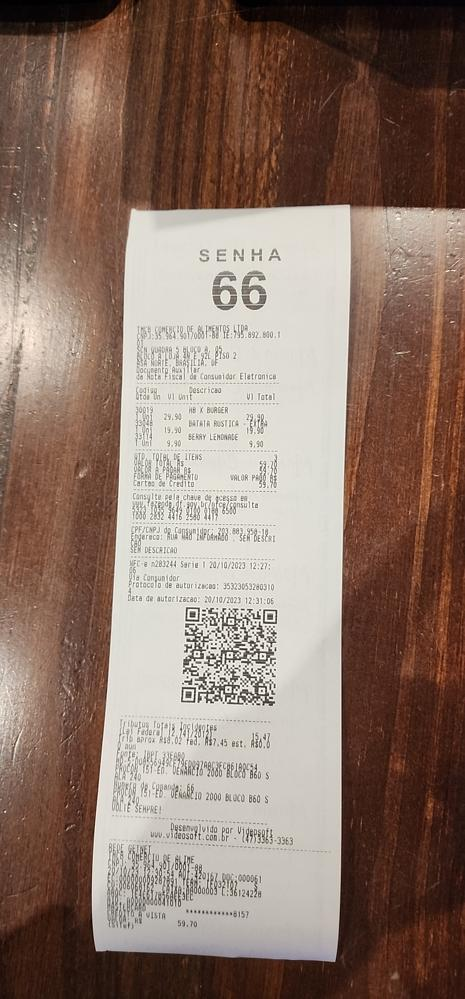

```json
{
  "empresa": "TACO COMERCIO DE ALIMENTOS LTDA",
  "data": "20/10/2023",
  "cnpj": "3596490170001",
  "tipo": "Alimentação",
  "itens": [
    {
      "descrição": "HB X BURGER",
      "valor_unitário": 29.90,
      "quantidade": 1,
      "valor_total": 29.90
    },
    {
      "descrição": "BATATA RUSTICA",
      "valor_unitário": 19.90,
      "quantidade": 1,
      "valor_total": 19.90
    },
    {
      "descrição": "BERRY LEMONADE",
      "valor_unitário": 9.90,
      "quantidade": 1,
      "valor_total": 9.90
    }
  ],
  "valor_pago": 59.70
}
```


In [ ]:
from google import genai
from google.genai import types
from dotenv import load_dotenv
import os
import PIL.Image
from IPython.display import display

load_dotenv()

def generate(image_path):
    client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))
    image = PIL.Image.open(image_path)
    display(image)
    text1 = """Dada a imagem de uma nota fiscal de compra, extraia os dados importantes dela e retorne no seguinte formato:
    - Empresa : nome da empresa que emitiu o recibo
    - Data: a data que foi feita a compra
    - CNPJ: cnpj da empresa que emitiu o recibo, sem pontuação
    - Tipo: tipo da despesa baseada nos itens comprados, escolha uma dentre as seguintes categorias:
                - Alimentação
                - Saúde
                - Mercado
                - Compras
                - Transporte
    - Itens: 
        - Descrição: nome ou descrição da mercadoria
        - Valor Unitário: valor unitário da mercadoria
        - Quantidade: quantidade da mercadoria
        - Valor Total: valor total da mercadoria
    - Valor Pago: valor pago
    Retorne os dados no formato JSON com nomes dos campos em snake_case."""

    model = "gemini-2.0-flash-001"
    generate_content_config = types.GenerateContentConfig(
        temperature = 1,
        top_p = 0.95,
        max_output_tokens = 8192,
        response_modalities = ["TEXT"],
    )
    response  = client.models.generate_content(
        model = model,
        contents = [text1, image],
        config = generate_content_config,
    )
    print(response.text)

generate(IMG_PATH)


# Tesseract - Apenas possivel com o tratamento de Imagem

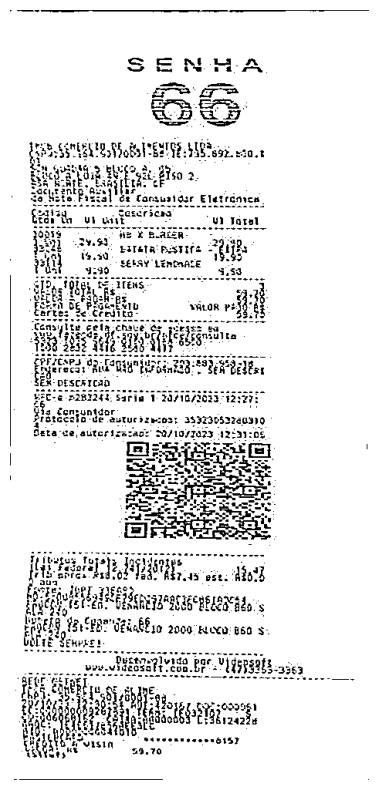

  
   

  

 

    

i/ 1912083 13im 06
r:x:—-.-._,_..
o E

   
 
 

 

 

SR o om o
AodetreR LAAMRENSRSASCARIENCAA,

Sf10 2000 ttoca: 860 s

ªgagãâãã Peladr2aads

..... ..s

    



In [ ]:
import numpy as np
import cv2
import pytesseract
from matplotlib import pyplot as plt


def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()


def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts


def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos


def transform_imagem(nome_imagem):
    img = cv2.imread(nome_imagem)
    original = img.copy()
    (H, W) = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = cv2.Canny(blur, 60, 160)
    conts = encontrar_contornos(edged.copy())
    for c in conts:
        peri = cv2.arcLength(c, True)
        aprox = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(aprox) == 4:
            maior = aprox
            break

    cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
    cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)

    pontosMaior = ordenar_pontos(maior)
    pts1 = np.float32(pontosMaior)
    pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

    matriz = cv2.getPerspectiveTransform(pts1, pts2)
    transform = cv2.warpPerspective(original, matriz, (W, H))
    
    img_process = cv2.cvtColor(transform, cv2.COLOR_BGR2GRAY)
    img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
    return img_process

img_final = transform_imagem(IMG_PATH)
mostrar(img_final)
 
config_tesseract = "--tessdata-dir tessdata"
texto = pytesseract.image_to_string(img_final, lang="por", config=config_tesseract)
print(texto)

